In [1]:
%%capture
!pip install transformers datasets adapters accelerate evaluate

In [2]:
# General
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
import datasets
from datasets import load_dataset

# DataLoader
from torch.utils.data import DataLoader

# Transformers
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    default_data_collator,
    T5Tokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    T5Config
)

# PEFT
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    PromptEncoderConfig
)

# Adapter
from adapters import AutoAdapterModel, AdapterConfig

# Evaluation
import evaluate

# Visualization
from sklearn.manifold import TSNE

from tqdm import tqdm
import gc
import evaluate
import torch
from torch.utils.data import DataLoader


2025-05-13 06:49:54.232188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747118994.457163      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747118994.527081      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# loading dataset
dataset = load_dataset("imdb", split=['train', 'test', 'unsupervised'])
dataset = datasets.DatasetDict({"train": dataset[0],"test": dataset[1], "unsupervised": dataset[2]})
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
if tokenizer.pad_token_id is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id

In [6]:
def tokenize(examples):
  model_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
  classes = ["negative", "positive"]
  label = [classes[label] for label in examples["label"]]
  labels = tokenizer(text_target=label, truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [7]:
tokenized_ds = dataset.map(tokenize, batched=True, num_proc=4, remove_columns=dataset["train"].column_names)

Map (num_proc=4):   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [8]:
train_ds = tokenized_ds["train"]
eval_ds = tokenized_ds["test"]

In [9]:
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=64, pin_memory=True) #wraps train dataset in data loader
eval_dataloader = DataLoader(eval_ds, batch_size=64, pin_memory=True) #wraps eval dataset in a Data Loader

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=None)

In [11]:
accuracy_metric = evaluate.load("accuracy")

In [12]:
def compute_metrics(eval_preds):
        preds, labels = eval_preds
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        pred_labels = [1 if pred.strip() == "positive" else 0 for pred in decoded_preds]
        true_labels = [1 if lab.strip() == "positive" else 0 for lab in decoded_labels]
        return accuracy_metric.compute(predictions=pred_labels, references=true_labels)


In [13]:

def get_trainer_and_adapter_model(r):


    # Load base model with adapter support
    model = AutoAdapterModel.from_pretrained("t5-small")

    # Add, activate, and train the adapter
    adapter_name = f"imdb_adapter_r{r}"
    adapter_config = AdapterConfig.load("houlsby", reduction_factor=r)
    model.add_adapter(adapter_name, config=adapter_config)
    model.train_adapter(adapter_name)
    model.set_active_adapters(adapter_name)
    print(model.adapter_summary())
    # Update data collator with the model
    data_collator.model = model

    # Training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=f"t5_adapter_imdb_r{r}",
        evaluation_strategy="no",
        save_strategy="no",
        eval_steps=500,
        save_steps=500,
        logging_steps=100,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        learning_rate=5e-5,
        weight_decay=0.01,
        predict_with_generate=True,
        fp16=torch.cuda.is_available(),
        report_to="none",
        disable_tqdm=False,
    )

   # Initialize Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    return trainer, model

In [14]:
results={}
reduction_factors = [4,8,16,32]
for r in reduction_factors:
    print(f"\n==== Training with Reduction factor: {r} ====")
    trainer, adapter_model = get_trainer_and_adapter_model(r)
   
    total_params = sum(p.numel() for p in adapter_model.parameters())
    trainable_params = sum(p.numel() for p in adapter_model.parameters() if p.requires_grad)
    trainable_pct = 100 * trainable_params / total_params

    train_result=trainer.train()
    gc.collect()
    torch.cuda.empty_cache()
    
    eval_result=trainer.evaluate(eval_dataset=eval_ds)
    train_time=train_result.metrics["train_runtime"]
    eval_time=eval_result["eval_runtime"]

    num_trainable_params = sum(p.numel() for p in adapter_model.parameters() if p.requires_grad)
    results[r] = {
        "train_loss": train_result.training_loss,
        "train_runtime": train_time,
        "eval_loss": eval_result.get("eval_loss"),
        "eval_accuracy": eval_result.get("eval_accuracy"),  # may vary depending on compute_metrics
        "eval_runtime": eval_time,
        "trainable_pct": trainable_pct,
    }

    print(f" Reduction factor {r} - Train loss: {train_result.training_loss:.4f}, Eval loss: {eval_result.get('eval_loss'):.4f}, Accuracy: {eval_result.get('eval_accuracy')}, Trainable params: {num_trainable_params}")
    print(f" Runtime: Train - {train_time:.2f}s, Eval - {eval_time:.2f}s")
    print(f" Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB, Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")



==== Training with Reduction factor: 4 ====


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r4          bottleneck        3,161,088       5.224       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_31/3393225385.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.638100
200,0.177200
300,0.152300
400,0.144900
500,0.144200
600,0.140900
700,0.137300
800,0.141700
900,0.138000


 Reduction factor 4 - Train loss: 0.3051, Eval loss: 0.1187, Accuracy: 0.9064, Trainable params: 3161088
 Runtime: Train - 849.84s, Eval - 539.05s
 Allocated: 0.31 GB, Reserved: 3.02 GB

==== Training with Reduction factor: 8 ====
Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r8          bottleneck        1,586,688       2.622       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_31/3393225385.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,2.989700
200,0.192400
300,0.163000
400,0.153200
500,0.152400
600,0.147600
700,0.146000
800,0.149000
900,0.144300


 Reduction factor 8 - Train loss: 0.4570, Eval loss: 0.1243, Accuracy: 0.89948, Trainable params: 1586688
 Runtime: Train - 839.61s, Eval - 530.53s
 Allocated: 0.29 GB, Reserved: 3.05 GB

==== Training with Reduction factor: 16 ====
Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r16         bottleneck          799,488       1.321       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_31/3393225385.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,5.680500
200,0.236700
300,0.174700
400,0.162000
500,0.159300
600,0.157200
700,0.152600
800,0.156400
900,0.151700


 Reduction factor 16 - Train loss: 0.7548, Eval loss: 0.1312, Accuracy: 0.89404, Trainable params: 799488
 Runtime: Train - 830.65s, Eval - 528.60s
 Allocated: 0.28 GB, Reserved: 3.13 GB

==== Training with Reduction factor: 32 ====
Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r32         bottleneck          405,888       0.671       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_31/3393225385.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,7.767600
200,0.415400
300,0.205900
400,0.172300
500,0.166900
600,0.165300
700,0.161000
800,0.164300
900,0.160100


 Reduction factor 32 - Train loss: 1.0052, Eval loss: 0.1380, Accuracy: 0.88784, Trainable params: 405888
 Runtime: Train - 828.38s, Eval - 530.48s
 Allocated: 0.27 GB, Reserved: 3.13 GB


In [15]:
results

{4: {'train_loss': 0.3050553389885428,
  'train_runtime': 849.8448,
  'eval_loss': 0.11871255934238434,
  'eval_accuracy': 0.9064,
  'eval_runtime': 539.047,
  'trainable_pct': 4.964978166641201},
 8: {'train_loss': 0.456969577537431,
  'train_runtime': 839.6113,
  'eval_loss': 0.12431330233812332,
  'eval_accuracy': 0.89948,
  'eval_runtime': 530.5258,
  'trainable_pct': 2.555328341963785},
 16: {'train_loss': 0.7548343919463559,
  'train_runtime': 830.6548,
  'eval_loss': 0.13124948740005493,
  'eval_accuracy': 0.89404,
  'eval_runtime': 528.6027,
  'trainable_pct': 1.3040918334537346},
 32: {'train_loss': 1.0052108906836301,
  'train_runtime': 828.3753,
  'eval_loss': 0.13804209232330322,
  'eval_accuracy': 0.88784,
  'eval_runtime': 530.4802,
  'trainable_pct': 0.6663458568249492}}

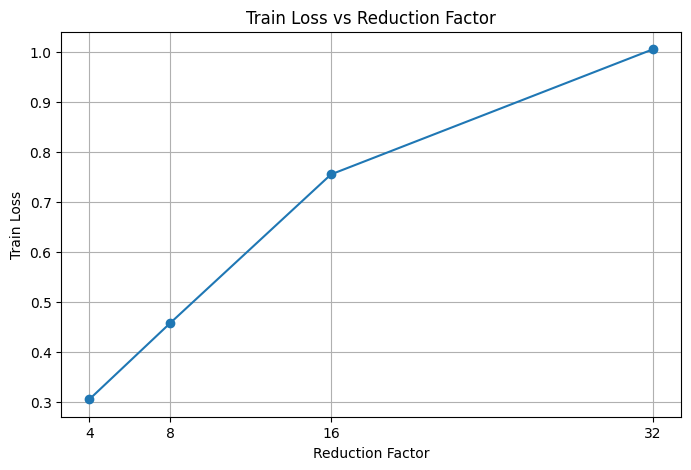

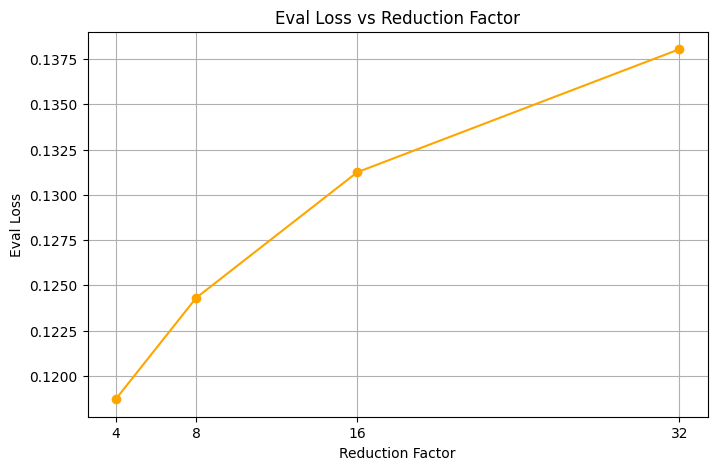

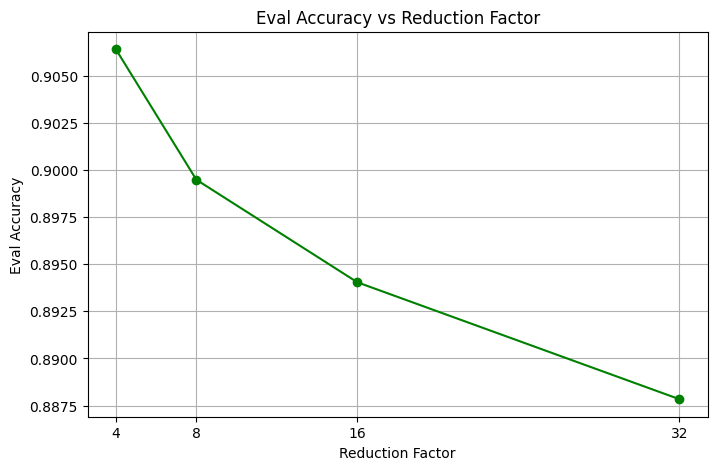

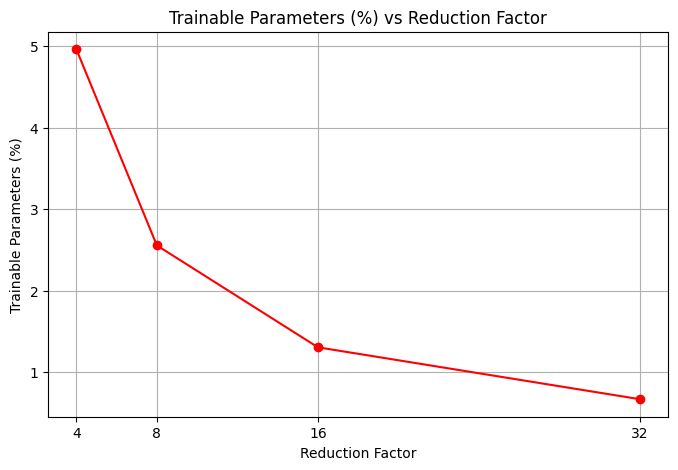

In [19]:
reduction_factors = list(results.keys())
train_loss = [results[r]['train_loss'] for r in reduction_factors]
eval_loss = [results[r]['eval_loss'] for r in reduction_factors]
eval_accuracy = [results[r]['eval_accuracy'] for r in reduction_factors]
trainable_pct = [results[r]['trainable_pct'] for r in reduction_factors]

# Plot 1: Train Loss
plt.figure(figsize=(8, 5))
plt.plot(reduction_factors, train_loss, marker='o')
plt.title("Train Loss vs Reduction Factor")
plt.xlabel("Reduction Factor")
plt.ylabel("Train Loss")
plt.xticks(reduction_factors)
plt.grid(True)
plt.show()

# Plot 2: Eval Loss
plt.figure(figsize=(8, 5))
plt.plot(reduction_factors, eval_loss, marker='o', color='orange')
plt.title("Eval Loss vs Reduction Factor")
plt.xlabel("Reduction Factor")
plt.ylabel("Eval Loss")
plt.grid(True)
plt.xticks(reduction_factors)
plt.show()

# Plot 3: Eval Accuracy
plt.figure(figsize=(8, 5))
plt.plot(reduction_factors, eval_accuracy, marker='o', color='green')
plt.title("Eval Accuracy vs Reduction Factor")
plt.xlabel("Reduction Factor")
plt.ylabel("Eval Accuracy")
plt.grid(True)
plt.xticks(reduction_factors)
plt.show()

# Plot 4: % Trainable Parameters
plt.figure(figsize=(8, 5))
plt.plot(reduction_factors, trainable_pct, marker='o', color='red')
plt.title("Trainable Parameters (%) vs Reduction Factor")
plt.xlabel("Reduction Factor")
plt.ylabel("Trainable Parameters (%)")
plt.xticks(reduction_factors)
plt.grid(True)
plt.show()

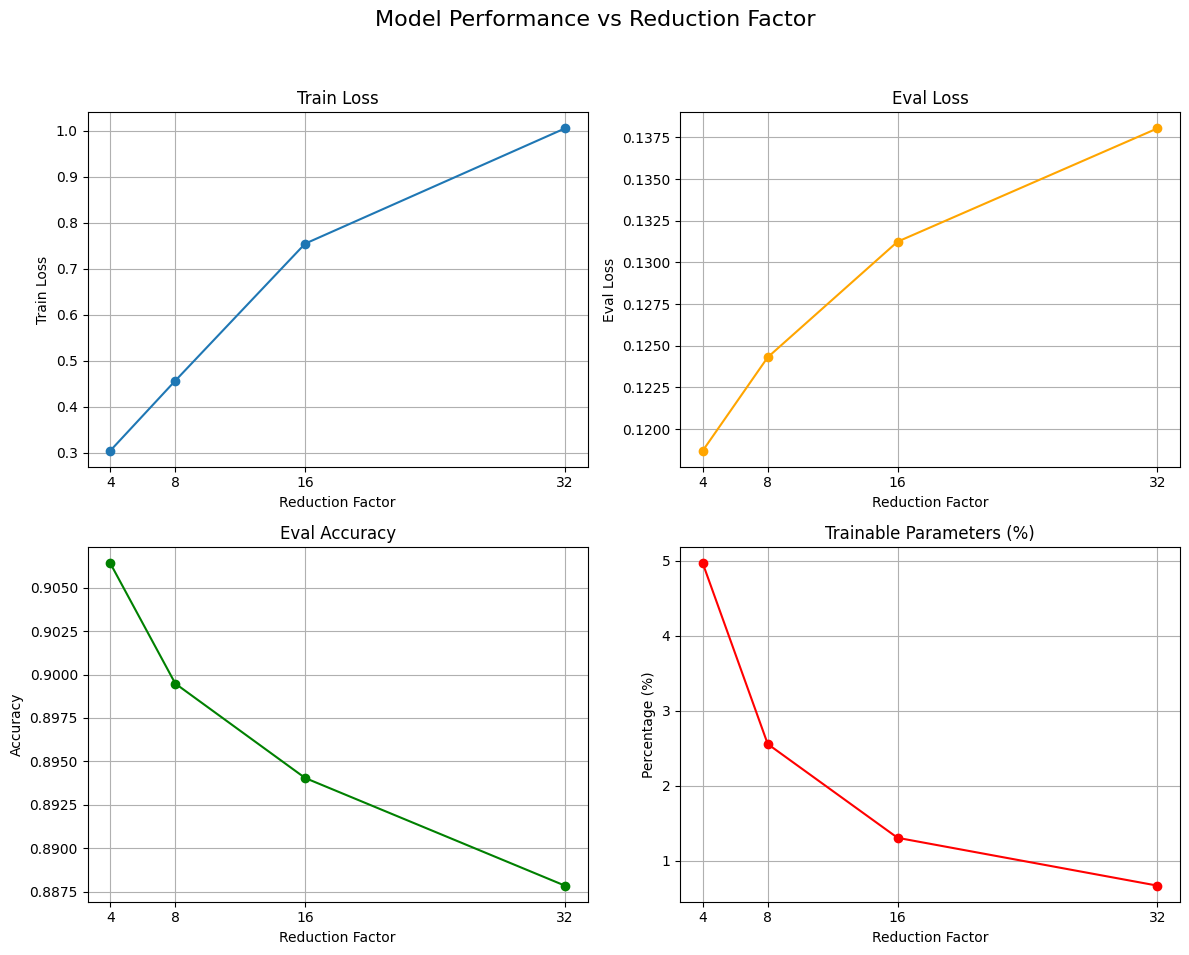

In [20]:

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Model Performance vs Reduction Factor", fontsize=16)

# Plot 1: Train Loss
axs[0, 0].plot(reduction_factors, train_loss, marker='o')
axs[0, 0].set_title("Train Loss")
axs[0, 0].set_xlabel("Reduction Factor")
axs[0, 0].set_ylabel("Train Loss")
axs[0, 0].set_xticks(reduction_factors)
axs[0, 0].grid(True)

# Plot 2: Eval Loss
axs[0, 1].plot(reduction_factors, eval_loss, marker='o', color='orange')
axs[0, 1].set_title("Eval Loss")
axs[0, 1].set_xlabel("Reduction Factor")
axs[0, 1].set_ylabel("Eval Loss")
axs[0, 1].set_xticks(reduction_factors)
axs[0, 1].grid(True)

# Plot 3: Eval Accuracy
axs[1, 0].plot(reduction_factors, eval_accuracy, marker='o', color='green')
axs[1, 0].set_title("Eval Accuracy")
axs[1, 0].set_xlabel("Reduction Factor")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_xticks(reduction_factors)
axs[1, 0].grid(True)

# Plot 4: % Trainable Parameters
axs[1, 1].plot(reduction_factors, trainable_pct, marker='o', color='red')
axs[1, 1].set_title("Trainable Parameters (%)")
axs[1, 1].set_xlabel("Reduction Factor")
axs[1, 1].set_ylabel("Percentage (%)")
axs[1, 1].set_xticks(reduction_factors)
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()